# Reloc2Df

In [1]:
import pandas as pd
import numpy as np
import subprocess
import shutil
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import json
from tqdm import tqdm
from glob import glob
from multiprocessing import Pool
import time

In [2]:
def process_hypodd_file(file_path):
    # Load the data from the file
    df = pd.read_csv(file_path, header=None, delimiter='\s+')

    # Rename the columns as specified
    column_names = [
        "ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", 
        "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "NCCP", "NCCS", 
        "NCTP", "NCTS", "RCC", "RCT", "CID"
    ]
    df.columns = column_names

    # Separate the seconds into whole seconds and fractional seconds
    df['whole_seconds'] = df['SC'].apply(lambda x: str(int(float(x))))
    df['fractional_seconds'] = df['SC'].apply(lambda x: f".{str(float(x)).split('.')[1]}" if '.' in str(x) else '.0')

    # Combine the date and time components
    df['origin_time'] = pd.to_datetime(
        df['YR'].astype(str) + '-' +
        df['MO'].astype(str).str.zfill(2) + '-' +
        df['DY'].astype(str).str.zfill(2) + ' ' +
        df['HR'].astype(str).str.zfill(2) + ':' +
        df['MI'].astype(str).str.zfill(2) + ':' +
        df['whole_seconds'], 
        errors='coerce', format='%Y-%m-%d %H:%M:%S'
    )

    # Add the fractional seconds
    df['origin_time'] = df['origin_time'] + pd.to_timedelta(df['fractional_seconds'].astype(float), unit='s')

    # Select and rename the relevant columns
    reloc_df = df[[
        'ID', 'origin_time', 'LON', 'LAT', 'DEPTH', 'MAG', 'CID'
    ]].copy()
    reloc_df.rename(columns={
        'ID': 'id', 
        'LON': 'lon', 
        'LAT': 'lat', 
        'DEPTH': 'depth', 
        'MAG': 'magnitude',
    }, inplace=True)

    return reloc_df


def ori_loc(file_path):
    # Load the data from the file
    df = pd.read_csv(file_path, header=None, delimiter='\s+')

    # Rename the columns as specified #ID, LAT, LON, DEPTH, X, Y, Z, EX, EY, EZ, YR, MO, DY, HR, MI, SC, MAG, CID
    column_names = [
        "ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", 
        "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "CID"
    ]
    df.columns = column_names

    # Separate the seconds into whole seconds and fractional seconds
    df['whole_seconds'] = df['SC'].apply(lambda x: str(int(float(x))))
    df['fractional_seconds'] = df['SC'].apply(lambda x: f".{str(float(x)).split('.')[1]}" if '.' in str(x) else '.0')

    # Combine the date and time components
    df['origin_time'] = pd.to_datetime(
        df['YR'].astype(str) + '-' +
        df['MO'].astype(str).str.zfill(2) + '-' +
        df['DY'].astype(str).str.zfill(2) + ' ' +
        df['HR'].astype(str).str.zfill(2) + ':' +
        df['MI'].astype(str).str.zfill(2) + ':' +
        df['whole_seconds'], 
        errors='coerce', format='%Y-%m-%d %H:%M:%S'
    )

    # Add the fractional seconds
    df['origin_time'] = df['origin_time'] + pd.to_timedelta(df['fractional_seconds'].astype(float), unit='s')

    # Select and rename the relevant columns
    loc_df = df[[
        'ID', 'origin_time', 'LON', 'LAT', 'DEPTH', 'MAG', 'CID'
    ]].copy()
    loc_df.rename(columns={
        'ID': 'id', 
        'LON': 'lon', 
        'LAT': 'lat', 
        'DEPTH': 'depth', 
        'MAG': 'magnitude', 
    }, inplace=True)

    return loc_df


def res2df(file_path):
    # Load the data from the file
    df = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None)
    
    # Define column names based on the provided structure
    column_names = [
        "STA", "DT", "C1", "C2", "IDX", "QUAL", "RES_MS", "WT", "OFFS"
    ]
    df.columns = column_names
    
    # Convert data types where appropriate
    df['DT'] = df['DT'].astype(float)
    df['C1'] = df['C1'].astype(int)
    df['C2'] = df['C2'].astype(int)
    df['IDX'] = df['IDX'].astype(int)
    df['QUAL'] = df['QUAL'].astype(float)
    df['RES_MS'] = df['RES_MS'].astype(float)
    df['RES_S'] = df['RES_MS']/1e3
    df['WT'] = df['WT'].astype(float)
    df['OFFS'] = df['OFFS'].astype(float)
    
    return df

In [14]:
df_res = res2df('D:/SERD/01_meq/03c_output_hypoDD/hypoDD.res')
#df_res.to_csv("res_wcc.csv",index=False)
filter = df_res[(df_res['IDX'] == 3) | (df_res['IDX'] == 4)]

In [18]:
filter

,STA,DT,C1,C2,IDX,QUAL,RES_MS,WT,OFFS,RES_S
245,RD06,0.055,1,19,3,1.0,44.048489,0.009803,764.3,0.044048
246,RD06,0.084,1,19,4,1.0,73.045105,0.007773,764.3,0.073045
247,RD05,0.022,1,19,3,1.0,39.603466,0.009816,764.3,0.039603
248,RD01,0.088,1,19,3,1.0,-6.207334,0.009829,764.3,-0.006207
249,RD04,0.113,1,19,3,1.0,-21.191082,0.009828,764.3,-0.021191
...,...,...,...,...,...,...,...,...,...,...
2300,RD01,-0.043,73,81,3,1.0,10.275438,0.009573,954.6,0.010275
2301,RD04,-0.195,73,74,3,1.0,-11.522709,0.009155,1165.5,-0.011523
2302,RD01,-0.330,73,74,4,1.0,-35.195049,0.007315,1165.5,-0.035195
2303,RD01,-0.190,73,74,3,1.0,-36.259598,0.009135,1165.5,-0.036260


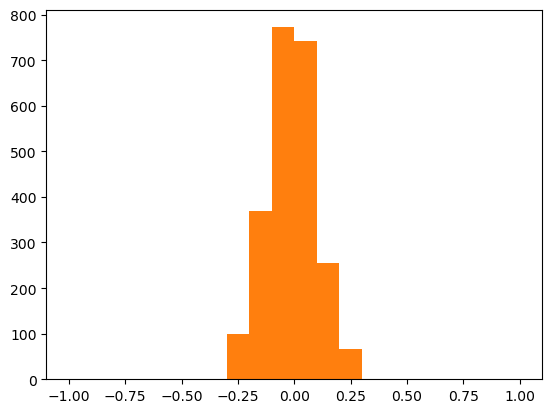

In [21]:
bin = np.arange(-1,1.1,0.1)
plt.hist(filter['RES_S'],bins=bin)
plt.hist(df_res['RES_S'],bins=bin)
plt.show()

In [17]:
bin

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00])

In [3]:
#df1 = process_hypodd_file("D:/SERD/01_meq/HYPODD/src/hypoDD/hypoDD1.reloc")
df1_reloc = process_hypodd_file('D:/SERD/01_meq/03c_output_hypoDD/hypoDD.reloc')

df1_ori = ori_loc('D:/SERD/01_meq/03c_output_hypoDD/hypoDD.loc')
# df2_ori = ori_loc('D:/SERD/01_meq/03c_output_hypoDD/2hypoDD.loc')

In [4]:
df1_reloc['depth']= df1_reloc['depth'] - 2.000
df1_reloc['elevation_m']= df1_reloc['depth'] *-1000
df1_reloc['remarks'] = 'WCC'
df1_reloc

,id,origin_time,lon,lat,depth,magnitude,CID,elevation_m,remarks
0,1,2024-11-01 14:56:39.930,103.371224,-4.208382,-0.195,0.0,1,195.0,WCC
1,2,2024-11-02 01:34:29.630,103.401587,-4.218960,0.222,0.0,1,-222.0,WCC
2,3,2024-11-04 18:50:07.800,103.345256,-4.229541,-0.084,0.0,1,84.0,WCC
3,4,2024-11-05 16:44:17.290,103.406038,-4.223671,-0.368,0.0,1,368.0,WCC
4,5,2024-11-05 16:57:56.610,103.356616,-4.240256,-0.186,0.0,1,186.0,WCC
...,...,...,...,...,...,...,...,...,...
60,72,2024-12-05 14:13:51.760,103.399268,-4.223628,-0.094,0.0,1,94.0,WCC
61,73,2024-12-05 14:13:57.550,103.402075,-4.218665,-0.433,0.0,1,433.0,WCC
62,74,2024-12-05 14:14:17.100,103.394971,-4.224651,0.113,0.0,1,-113.0,WCC
63,78,2024-12-08 10:00:15.940,103.360156,-4.245156,-0.200,0.0,1,200.0,WCC


In [5]:
df1_ori['depth']= df1_ori['depth'] - 2.000
df1_ori['elevation_m']= df1_ori['depth'] *-1000
df1_ori['remarks'] = 'Reloc'
df1_ori
df1_ori

,id,origin_time,lon,lat,depth,magnitude,CID,elevation_m,remarks
0,1,2024-11-01 14:56:39.860,103.373802,-4.2084,-0.002,0.0,1,2.0,Reloc
1,2,2024-11-02 01:34:29.610,103.408600,-4.2104,0.394,0.0,1,-394.0,Reloc
2,3,2024-11-04 18:50:07.840,103.362999,-4.2413,0.295,0.0,1,-295.0,Reloc
3,4,2024-11-05 16:44:17.160,103.398399,-4.2250,0.069,0.0,1,-69.0,Reloc
4,5,2024-11-05 16:57:56.680,103.365997,-4.2378,-0.695,0.0,1,695.0,Reloc
...,...,...,...,...,...,...,...,...,...
73,77,2024-12-07 11:50:40.730,103.382698,-4.2297,0.394,0.0,1,-394.0,Reloc
74,78,2024-12-08 10:00:16.000,103.349899,-4.2424,-0.384,0.0,1,384.0,Reloc
75,79,2024-12-08 11:52:40.710,103.354599,-4.2396,-1.550,0.0,1,1550.0,Reloc
76,80,2024-12-08 16:19:23.400,103.358299,-4.2396,-1.621,0.0,1,1621.0,Reloc


In [6]:
new_rows = df1_ori[~df1_ori['id'].isin(df1_reloc['id'])]

# Gabungkan df1 dengan baris baru dari df2
merged_df = pd.concat([df1_reloc, new_rows], ignore_index=True)
merged_df = merged_df.sort_values(by='id', ignore_index=True)
merged_df

,id,origin_time,lon,lat,depth,magnitude,CID,elevation_m,remarks
0,1,2024-11-01 14:56:39.930,103.371224,-4.208382,-0.195,0.0,1,195.0,WCC
1,2,2024-11-02 01:34:29.630,103.401587,-4.218960,0.222,0.0,1,-222.0,WCC
2,3,2024-11-04 18:50:07.800,103.345256,-4.229541,-0.084,0.0,1,84.0,WCC
3,4,2024-11-05 16:44:17.290,103.406038,-4.223671,-0.368,0.0,1,368.0,WCC
4,5,2024-11-05 16:57:56.610,103.356616,-4.240256,-0.186,0.0,1,186.0,WCC
...,...,...,...,...,...,...,...,...,...
73,77,2024-12-07 11:50:40.730,103.382698,-4.229700,0.394,0.0,1,-394.0,Reloc
74,78,2024-12-08 10:00:15.940,103.360156,-4.245156,-0.200,0.0,1,200.0,WCC
75,79,2024-12-08 11:52:40.710,103.354599,-4.239600,-1.550,0.0,1,1550.0,Reloc
76,80,2024-12-08 16:19:23.400,103.358299,-4.239600,-1.621,0.0,1,1621.0,Reloc


In [7]:
merged_df.to_csv("reloc.csv",index=False)

In [8]:
# concat_reloc = pd.concat([df1, df2], ignore_index=True)
# concat_loc = pd.concat([df1_ori, df2_ori], ignore_index=True)

In [9]:
# nll_cat = pd.read_excel("D:/SERD/NonLinLoc/SERD_WORKDIR/2024_11.xlsx")
# nll_cat.rename(columns={
#         'ID': 'id', 
#         'Lon': 'lon', 
#         'Lat': 'lat', 
#         'Depth': 'depth', 
#     }, inplace=True)

# # Konversi semua komponen waktu ke string dan pastikan T0 adalah string
# nll_cat['T0'] = nll_cat['T0'].astype(str)
# nll_cat['origin_time'] = pd.to_datetime(
#     nll_cat['Year'].astype(str) + '-' +
#     nll_cat['Month'].astype(str).str.zfill(2) + '-' +
#     nll_cat['Day'].astype(str).str.zfill(2) + ' ' +
#     nll_cat['Hour'].astype(str).str.zfill(2) + ':' +
#     nll_cat['Minute'].astype(str).str.zfill(2) + ':' +
#     nll_cat['T0'], 
#     errors='coerce', format='%Y-%m-%d %H:%M:%S.%f'
# )
# nll_cat['magnitude'] = 0
# nll_cat['cid'] = 0
# nll_cat = nll_cat[['id', 'origin_time', 'lon', 'lat', 'depth', 'magnitude', 'cid']]
# nll_cat

In [10]:
# new_rows = nll_cat[~nll_cat['id'].isin(merged_df['id'])]

# # Gabungkan df1 dengan baris baru dari df2
# merged_df2 = pd.concat([merged_df, new_rows], ignore_index=True)
# merged_df2 = merged_df2.sort_values(by='id', ignore_index=True)
# merged_df2

In [11]:
# merged_df2.to_csv("reloc.csv",index=False)

In [12]:
# merged_df2